#  Poor Control Inspite of Perfect Prediction  

It seems logical that if you want to control something, you need to measure it and predict it. 

For example, if you want to achieve a particular health outcome like blood glucose level, measuring it, predicting its response to nutrition, exercise and medication seems sufficient. Once you can predict it well, then achieving your goal of controlling it appears a matter of diligent execution. 

We all know from personal experience, that it is easier said than done. 

I want to systematically explore surprises that occur along the way. In doing so, I want to point out various method pitfalls relating to human decisions. Sometimes, these pitfalls are present in computer automation methods.   

Although I describe a dose-response problem, the method pitfalls apply equally well to biological and non-living processes.

You will be making interactive human decisions on the simulated examples where we are testing human decision making.  

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation,rc
#from IPython.display import HTML
import ipywidgets

###  Predict and Control

In the simplest interactive problem below, you can first predict what the output will be when you choose a particular value for the input decision variable using the slider (like a medication dose).  Choose the best value you deem appropriate until the prediction hits the target reference and then execute the decision using the execute button. 

Your goal is to make the output equal to the fixed target reference value displayed. 

#### Perfect Prediction of Output to be Controlled

Constant $A,B,C,D$  define a state space system. In discrete time, 

$$\begin {align} x(t+1)=A*x(t)+B*u(t) \\ y(t)=C*x(t)+D*u(t) \end {align}$$

Initial state $x(0)=x_0$ is randomly chosen with a mean value of 5.  We assume further that there is no noise or disturbance in the system and the constants $A,B,C,D$ are known exactly.

You will be able to predict perfectly because there is no noise and you have access to an exact determiniatic simulation. If you predict based upon an input value, you will get exactly the predicted output upon execution. You can keep changing the input until you hit the target output for the predicted value. 

This is a very ideal situation intended to illustrate a particular class of problems in controlling dynamical system.  

In [11]:
#initialize a non-minimum phase stable state space system
A=0.7;B=2.5;C=1;D=1;
x_0=np.random.randn()*1+5;
print("Initial State x(0) = ", x_0)


Initial State x(0) =  6.061571451667506


###  Interactive Prediction and Control
Now, let us see what happens when you try to control it.  

Your goal is to make the output response close to $y(t) = 5.0$.  

Before you actually execute the decision with a particular value of input dose u(t), you can move the slider input, then hit the __Predict Response(t+1)__ button to see the predicted y.  Prediction does not propagate the state, it merely uses the current state and the input to compute the predicted y(t+1). When you are satisfied with the value u(t), you can commit and hit the __Administer Dose(t)__ button, which results in propagation of the state space recursion. 

It will give you hints for next step such as to increase or decrease the trial input Dose u(t).  Highlighted buttons are available for interaction.  When the predicted output response y(t+1) is within range, it will allow you to administer the Dose. For the first time, you need not bring the response within range to administer the dose.
 
First, we lay out the interaction and propagation of the system. Then we display the progress of your interaction with this dynamical system.

FloatSlider(value=0.0, description='Dose(t)', layout=Layout(width='95%'), max=10.0, min=-10.0, step=0.01)

<IPython.core.display.Javascript object>


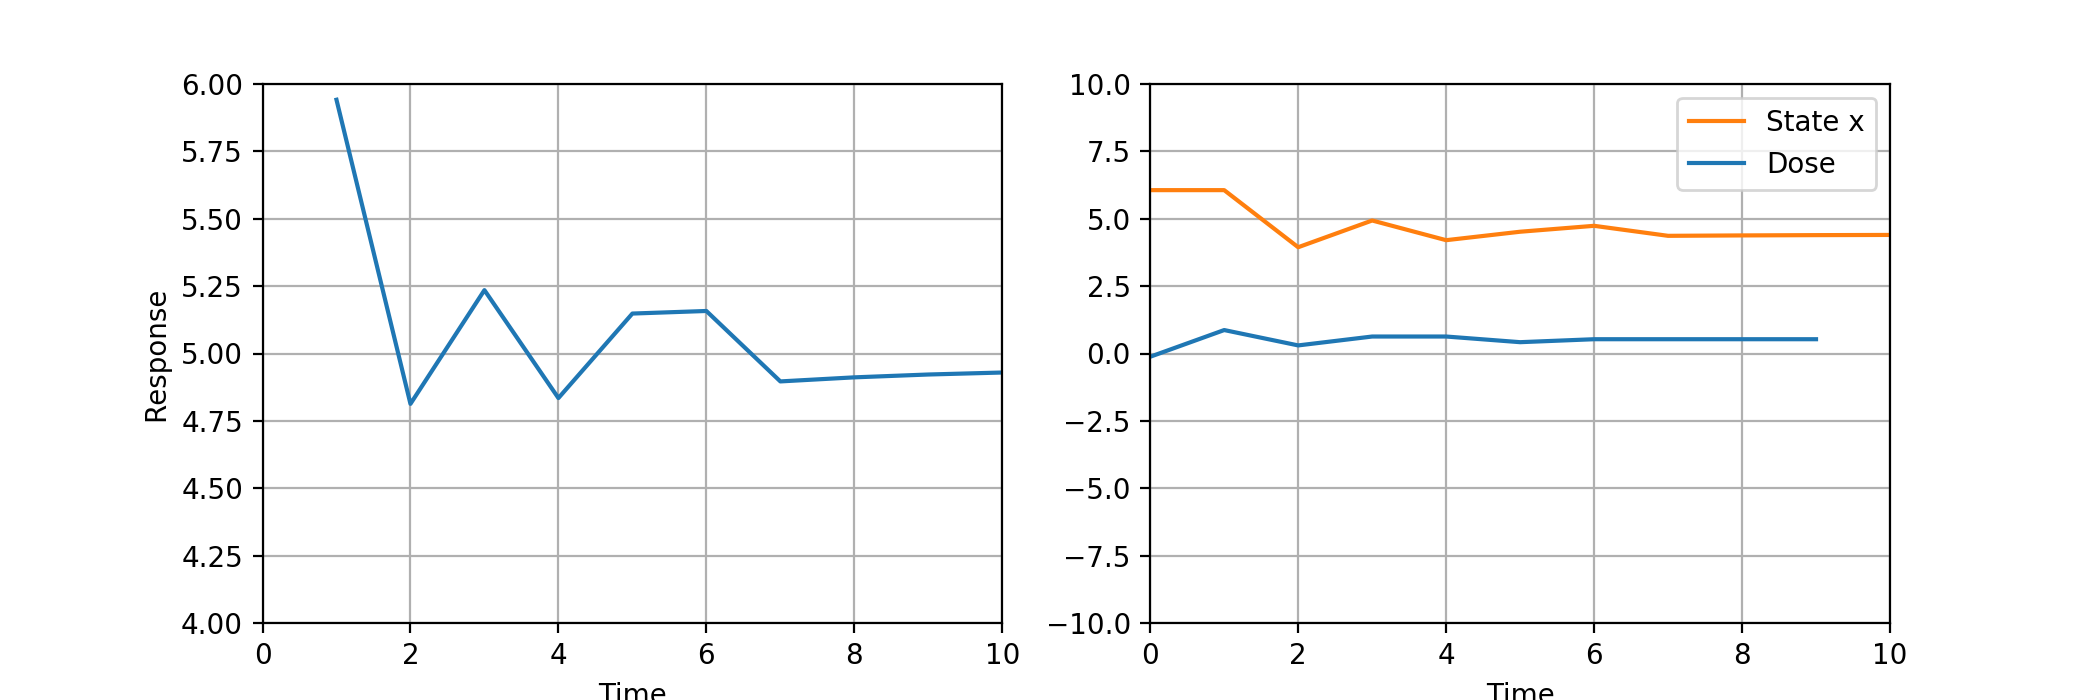

In [12]:
#  Define display interaction widgets
a1=ipywidgets.FloatSlider(description='Dose(t)',
                        min=-10.0,max=10.0,step=.01,layout=ipywidgets.Layout(width='95%'))

nudge_text=ipywidgets.Text(description="Next Step",value='Predict Response(t+1)  ')   
y_text=ipywidgets.Text(description='Response(t+1) ',value='  ',style={'description_width':'initial'})
#  Define data storage vectors for plotting
nT=11;
t_data=np.linspace(0,nT-1,nT)
y_data=np.zeros(nT)
y_data.fill(np.nan)
x_data=np.zeros(nT)
x_data.fill(np.nan)
u_data=np.zeros(nT)
u_data.fill(np.nan)
t=0;
x=x_0;      # Initialize state
x_data[0]=x
threshold=.25
ref=5
u_upper_limit=10
u_lower_limit=-10
y_str_upper=' (is more than '+'{:.4}'.format(str(ref+threshold)) +')'
y_str_lower=' (is less than '+'{:.4}'.format(str(ref-threshold))+')'
# "Predict y (t+1)": for given input u and state x
def on_pred_clicked(b):
    global x,t
    u=a1.value
    y_pred=C*x+D*u
    y_str='{:.4}'.format(str(C*x+D*u))
    exec_button.disabled=True    # disable exec button 
    if y_pred > ref+threshold:       # Prediction too high
        if u <= u_lower_limit:
            nudge_text.value='Hit lower tox limit'
        else:  
            nudge_text.value='Reduce dose(t) and Predict'
            y_text.value = y_str+y_str_upper  
    elif y_pred < ref-threshold:     # prediction too low
        if u >= u_upper_limit:
            nudge_text.value='Hit upper tox limit'
        else: 
            nudge_text.value ='Increase dose(t) and Predict'
            y_text.value=y_str+y_str_lower
    else:                       # pediction in range
        y_text.value=y_str + ' (in range)'
        nudge_text.value ='Administer dose(t)'
        exec_button.disabled=False      # enable exec button
        pred_button.disabled=True       # disable predict button
    if t==0:
        exec_button.disabled=False          #  For first time do not restrict to strict prediction
        pred_button.disabled=False          #  
           
# "Execute u (t)": for given input u, computes y and propagates state x using u
def on_exec_clicked(b):
    global x,t,nT
    if t+1 <= nT-1:
        u=a1.value
        u_data[t]=u
        y=C*x+D*u
        y_data[t+1]=y
     
        y_text.value='{:.4}'.format(str(y))
        x_data[t+1]=x
        x=A*x+B*u # propagate state
        t=t+1
        plot_progress()
        nudge_text.value='Predict Response(t+1)'
        pred_button.disabled=False         # Enable predict button   
        exec_button.disabled=True          # Disable exec button
    else:
        nudge_text.value='Successful Completion'
        pred_button.disabled=True
        exec_button.disabled=True
# plot data progress
def plot_progress():
    global t_data,x_data,y_data,u_data,y_line,u_line,x_line,fig2,ax2,ax3
    y_line.set_ydata(y_data)
    u_line.set_ydata(u_data)
    x_line.set_ydata(x_data)
    
exec_button=ipywidgets.Button(description="Administer Dose(t)",disabled=True,
                              layout=ipywidgets.Layout(width='42%'))
exec_button.on_click(on_exec_clicked)
pred_button=ipywidgets.Button(description="Predict Response(t+1)",disabled=False,
                              layout=ipywidgets.Layout(width='42%'))
pred_button.on_click(on_pred_clicked)

#  Layout action buttons and info boxes
action_box=ipywidgets.HBox([pred_button,exec_button],
                          layout=ipywidgets.Layout(justify_content='center'))
info_box=ipywidgets.HBox([y_text,nudge_text],
                        layout=ipywidgets.Layout(justify_content='center'))
y_text.disabled=True;
display(a1)
display(info_box)
display(action_box)

fig1=plt.figure(1,figsize=(10.5,3.5))
ax2=fig1.add_subplot(1,2,1)
y_line, = ax2.plot(t_data,y_data)
plt.grid(True)
plt.xlim(0,10)
plt.ylim(4,6)
plt.xlabel('Time')
plt.ylabel('Response')
ax3=fig1.add_subplot(1,2,2)
u_line,  = ax3.plot(t_data,u_data)
x_line,  = ax3.plot(t_data,x_data)
plt.legend((x_line,u_line),('State x','Dose'))
plt.grid(True)
plt.xlim(0,10)
plt.ylim(-10,10)
plt.xlabel('Time');


If you have been very dilligent about bringing prediction close to the target at each time point, you will see 
that while the output remains tightly regulated, both inputs $u(t)$ and state $x(t)$ are oscillating and blowing up! 

So, with prefect prediction and output control, this system often blows up. 

On the other hand, for some initial states, if you happen to do just enough to get the response in the range an not move the input much you will successfully complete the ten steps. 

One is reminded of the adage "Be careful what you wish for" and "Unintended consequences".  It is remarkable that this happens with a trivially simple, stable, eniterly deterministic and predictable linear dynamical system.

Saved y(t) values: [       nan 5.94157145 4.81310002 5.23517001 4.83461901 5.14823331
 5.15776331 4.89643432 4.91150402 4.92205282 4.92943697]
Saved u(t) values: [-0.12  0.87  0.3   0.63  0.63  0.42  0.53  0.53  0.53  0.53   nan]


<IPython.core.display.Javascript object>


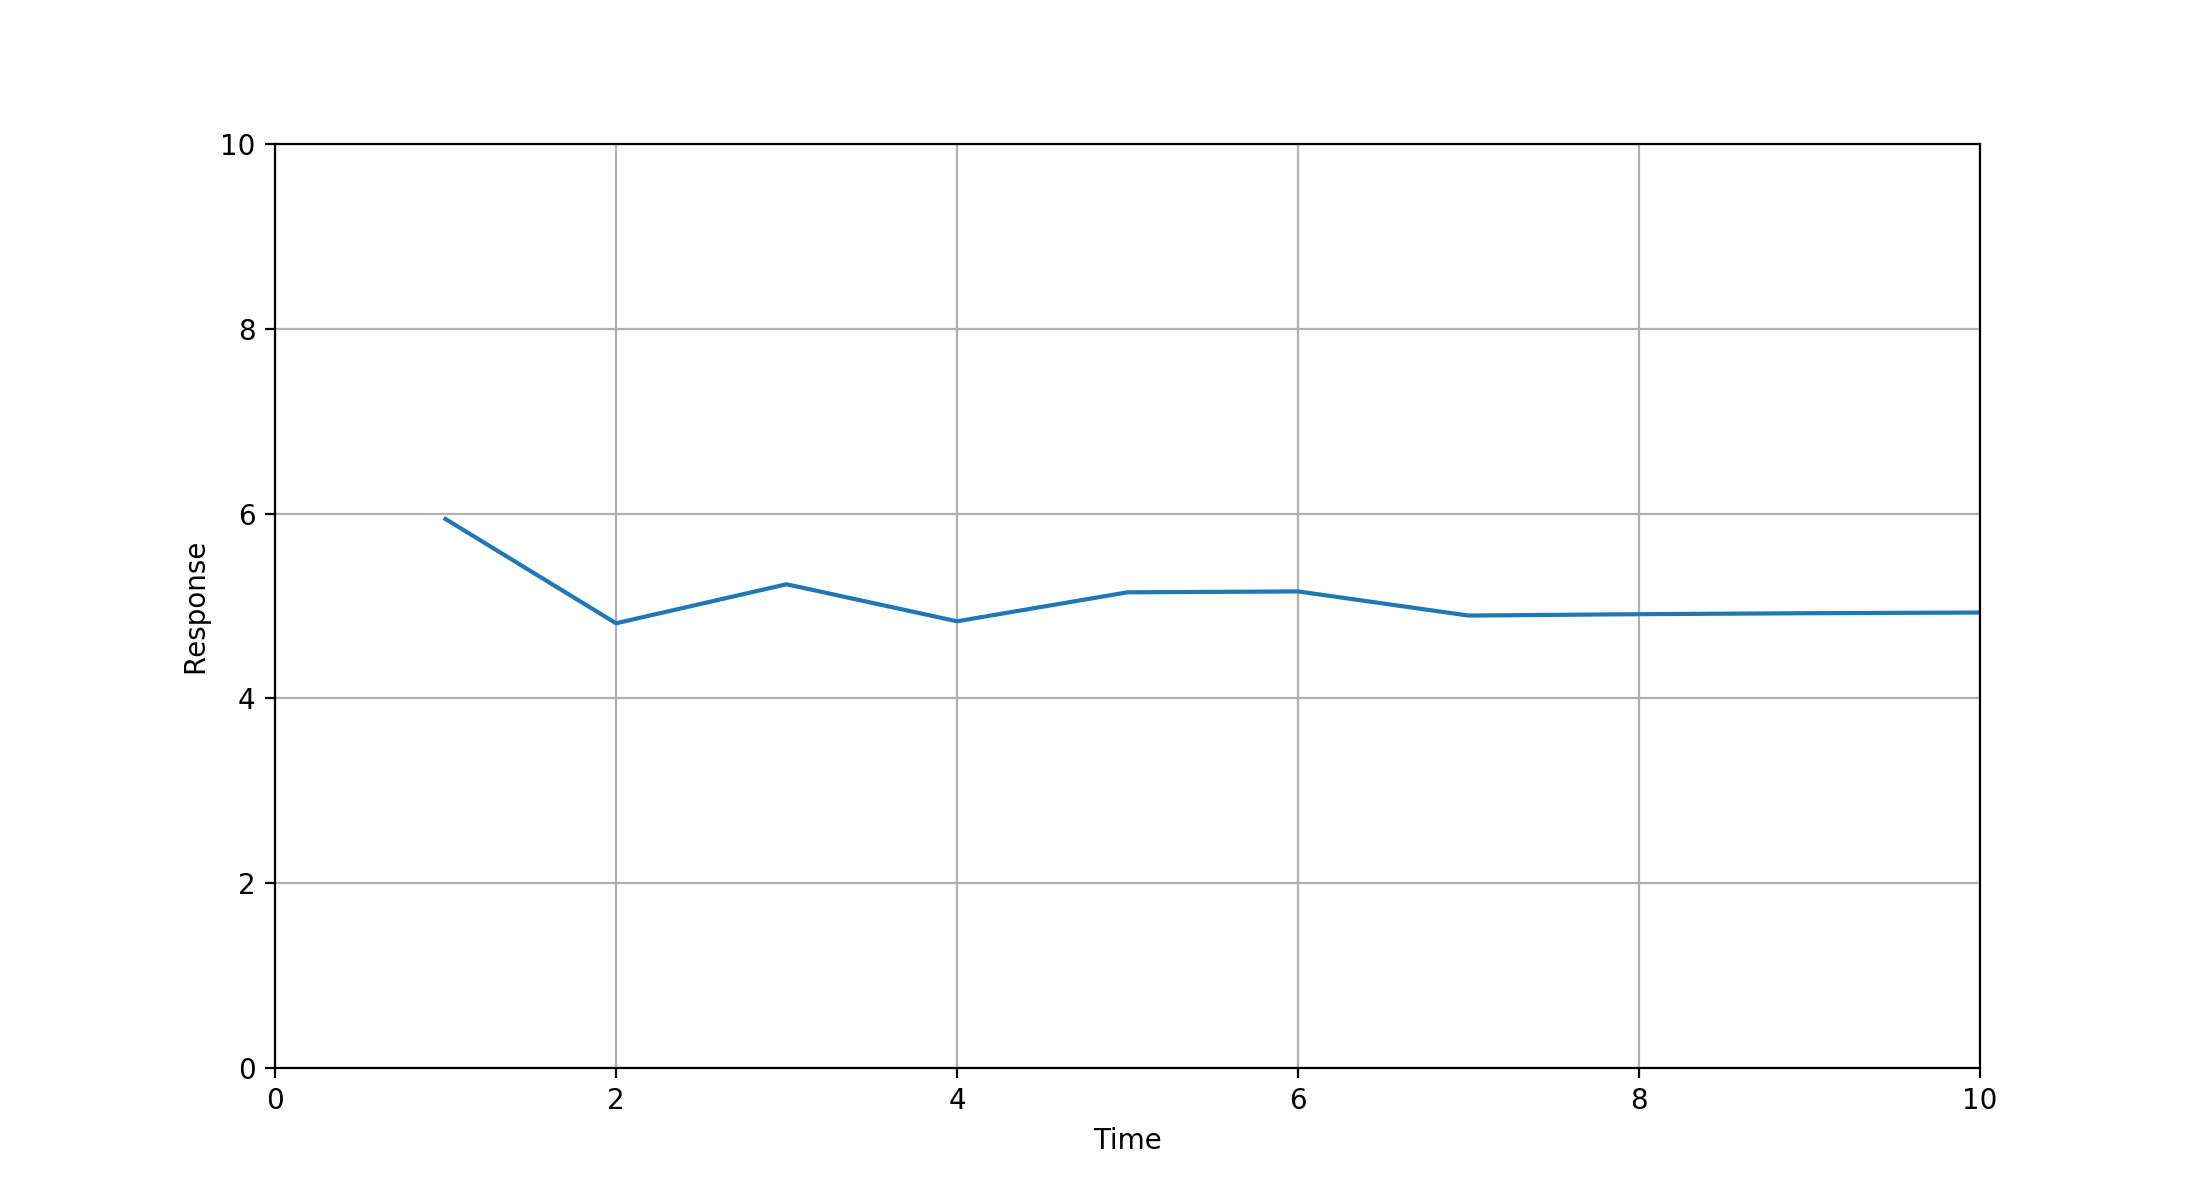

<IPython.core.display.Javascript object>


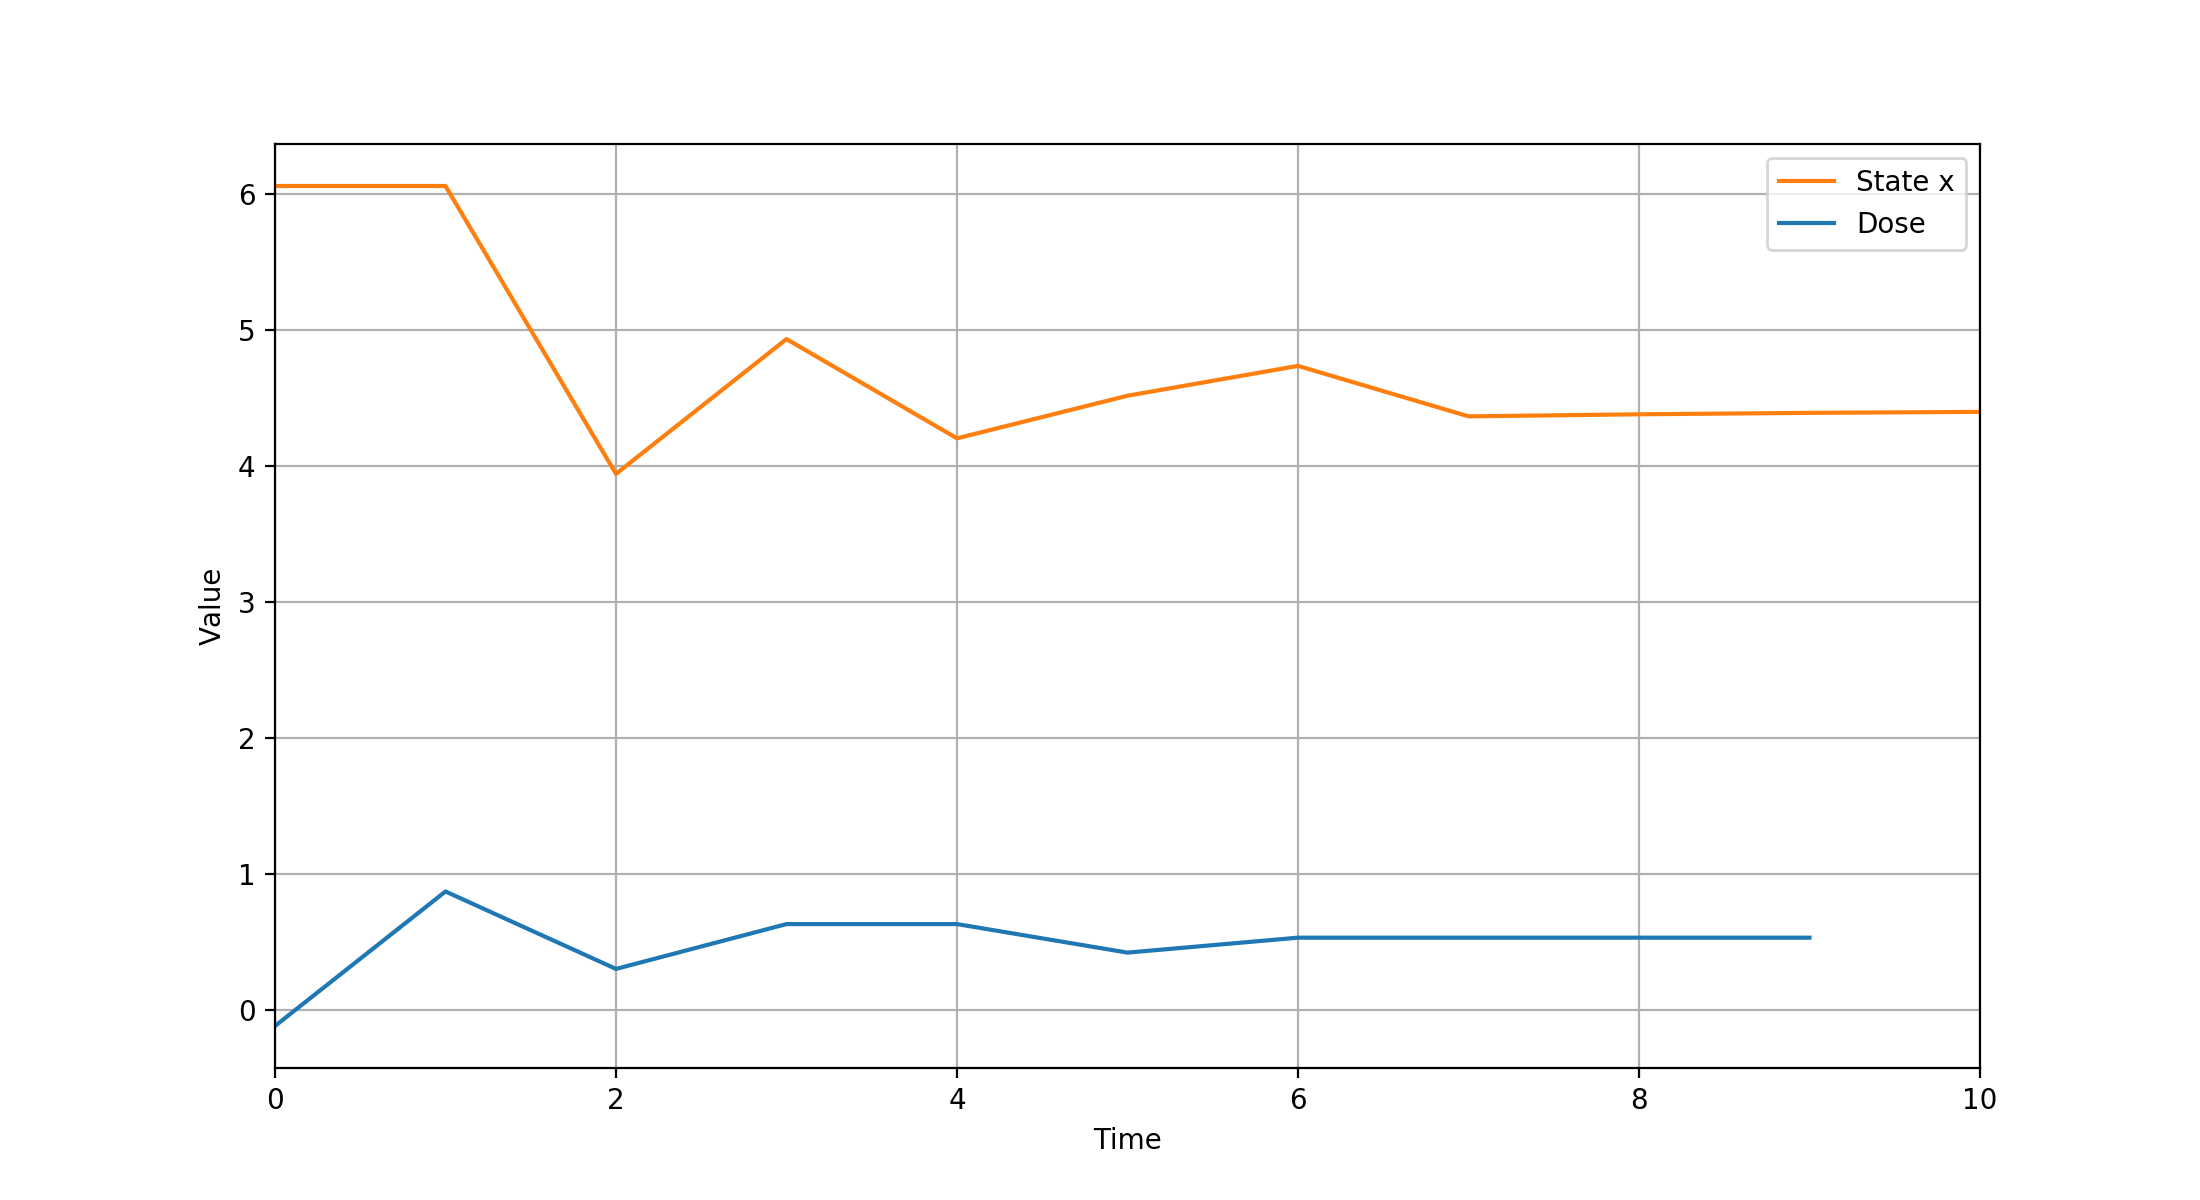

In [13]:
print('Saved y(t) values:',y_data)
print('Saved u(t) values:',u_data)
fig4=plt.figure(3,figsize=(11,6))
plt.plot(t_data,y_data)
plt.grid(True)
plt.xlim(0,10)
plt.ylim(0,10)
plt.xlabel('Time')
plt.ylabel('Response');
#fig4.canvas.draw()
fig5=plt.figure(4,figsize=(11,6))
u_line, = plt.plot(t_data,u_data)
x_line, = plt.plot(t_data,x_data)
plt.legend((x_line,u_line),('State x','Dose'))
plt.grid(True)
plt.xlim(0,10)
plt.xlabel('Time')
plt.ylabel('Value');
#fig5.canvas.draw()

### A Dose of Reality

Let us move from the ideal situation to a more realistic scenario.

+ Unknown or approximate model

    Human decision makers often use immediate aggregate cause-effect heuristics. If the blood glucose shot up, it was most likely the glass of wine with the last meal. If the stock market lost one percent, it was because of the latest news on trade war.
    

+ Many decision variables affect observations
   
  When multiple decision variables are involved, humans focus on one assumed dominant variable. The mental burden of untangling multiple causes is too large. Doing so for a dynamic system with continuous variables is clearly just too complex for humans.
  

+ Too many extraneous conditions and variables affect observations

   Given the simplfied cause-effect heuristic, the apparent variability of observations becomes large. You often hear that the variablity is due to inherent random behavior that can only be untangeled by averaging over many experiments and observations. To the poor patient, the averaging is of little comfort. Loss of agency and hope for the patient leads do resignation and even depression.  Apparent variability also occurs in machine learned models when the representations are poorly chosen in dynamic systems. 
   

+ Can not directly measure what you need to really maintain or control
   
   In metabolic syndrome, you need to arrest or reduce organ damage, mental depression and other co-morbidity.  However, blood prick glucose measurement or readings from CGM need to be translated to what you need to be concerend with.  Your camera sensor output on an autonomous car will give you a partial and possibly misleading view of the environment, leading to accidents. 
   
We will go over each of these aspects and see how it manifests in simulated examples.  

Again, no need to take my word on it. You will be the decision maker  in the simulated examples!
  
      

